In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import CIFAR10
from torchvision.models.resnet import resnet34
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
noisy_path = "../../../data/noisylabels/CIFAR-10_human.pt"
noisy_labels = {k: torch.tensor(v) for k, v in torch.load(noisy_path).items()}
keys_to_test = ["aggre_label", "random_label1", "worse_label"]
noisy_labels

{'clean_label': tensor([6, 9, 9,  ..., 9, 1, 1]),
 'aggre_label': tensor([6, 9, 9,  ..., 9, 1, 1]),
 'worse_label': tensor([4, 9, 0,  ..., 9, 1, 1]),
 'random_label1': tensor([6, 9, 9,  ..., 9, 1, 1]),
 'random_label2': tensor([4, 9, 9,  ..., 9, 1, 1]),
 'random_label3': tensor([6, 9, 0,  ..., 9, 1, 1])}

In [3]:
cifar10_train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

clean_dataset = CIFAR10("../../../data/cifar", train=True, transform=cifar10_train_transform)
clean_labels = torch.tensor(clean_dataset.targets)
clean_labels

tensor([6, 9, 9,  ..., 9, 1, 1])

In [4]:
def generate_synthetic_labels(clean_labels, noisy_labels, seed=1337):
    # generate transition matrix T
    num_classes = 10
    T = torch.zeros(num_classes, num_classes)
    for i in range(num_classes):
        clean_mask = clean_labels == i
        for j in range(num_classes):
            p = (noisy_labels[clean_mask] == j).float().mean()
            T[i, j] = p
    
    # sample the transition matrix
    gen = torch.Generator("cpu").manual_seed(seed)
    synthetic_labels = torch.multinomial(T[clean_labels], 1, generator=gen).squeeze()
    return synthetic_labels

generate_synthetic_labels(clean_labels, noisy_labels["aggre_label"])

tensor([6, 9, 9,  ..., 9, 1, 1])

In [5]:
def train_and_record_memorization(clean_labels, noisy_labels, num_epochs):
    dataset = clean_dataset
    dataset.targets = noisy_labels
    confidence_threshold = 0.95

    model = resnet34(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    loader = torch.utils.data.DataLoader(
        clean_dataset, batch_size=128, shuffle=False)
    
    clean_memos = []
    wrong_memos = []
    for epoch in range(num_epochs):
        probs = []
        for x, y in (pbar := tqdm(loader, ncols=80, desc=f"{epoch=:3}")):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            probs.append(F.softmax(y_pred, -1))
            pbar.set_postfix({"loss": f"{loss.item():.2e}"})
        
        probs = torch.cat(probs)
        clean_idxs = clean_labels == noisy_labels        
        clean_frac = (probs[ clean_idxs].max(axis=-1)[0] > confidence_threshold).float().mean()
        wrong_frac = (probs[~clean_idxs].max(axis=-1)[0] > confidence_threshold).float().mean()
        clean_memos.append(clean_frac.item())
        wrong_memos.append(wrong_frac.item())
    
    return clean_memos, wrong_memos

In [6]:
# num_epochs = 150
# memo_results = {}
# for key in keys_to_test:
#     print(f"\ntraining with {key}\n")
#     memo_results[key] = {}
    
#     human_labels = noisy_labels["aggre_label"]
#     synth_labels = generate_synthetic_labels(clean_labels, human_labels)
    
#     print(f"training human")
#     human = train_and_record_memorization(clean_labels, human_labels, num_epochs)
#     print(f"training synthetic")
#     synth = train_and_record_memorization(clean_labels, synth_labels, num_epochs)

#     memo_results[key]["human"] = {"clean": human[0], "wrong": human[1]}
#     memo_results[key]["synthetic"] = {"clean": synth[0], "wrong": synth[1]}
# torch.save(memo_results, "memo_results.pt")

In [7]:
results = dict()
seeds = [1337, 42, 1]
for seed in seeds:
    memo_results = torch.load(f"memo_results_{seed}.pt")
    results[seed] = memo_results

In [8]:
memo_results_mean = {}
memo_results_unc = {}
for key in keys_to_test:
    human_clean = []
    human_wrong = []
    synthetic_clean = []
    synthetic_wrong = []
    for seed in seeds:
        human_clean.append(results[seed][key]["human"]["clean"])
        human_wrong.append(results[seed][key]["human"]["wrong"])
        synthetic_clean.append(results[seed][key]["synthetic"]["clean"])
        synthetic_wrong.append(results[seed][key]["synthetic"]["wrong"])
    human_clean = torch.tensor(human_clean)
    human_wrong = torch.tensor(human_wrong)
    synthetic_clean = torch.tensor(synthetic_clean)
    synthetic_wrong = torch.tensor(synthetic_wrong)
    memo_results_mean[key] = {
        "human": {"clean": human_clean.mean(0), "wrong": human_wrong.mean(0)},
        "synthetic": {"clean": synthetic_clean.mean(0), "wrong": synthetic_wrong.mean(0)},
    }
    memo_results_unc[key] = {
        "human": {"clean": human_clean.std(0) / np.sqrt(human_clean.shape[0]), 
                  "wrong": human_wrong.std(0) / np.sqrt(human_wrong.shape[0])
                  },
        "synthetic": {"clean": synthetic_clean.std(0) / np.sqrt(synthetic_clean.shape[0]), 
                      "wrong": synthetic_wrong.std(0) / np.sqrt(synthetic_wrong.shape[0])
                      }
    }

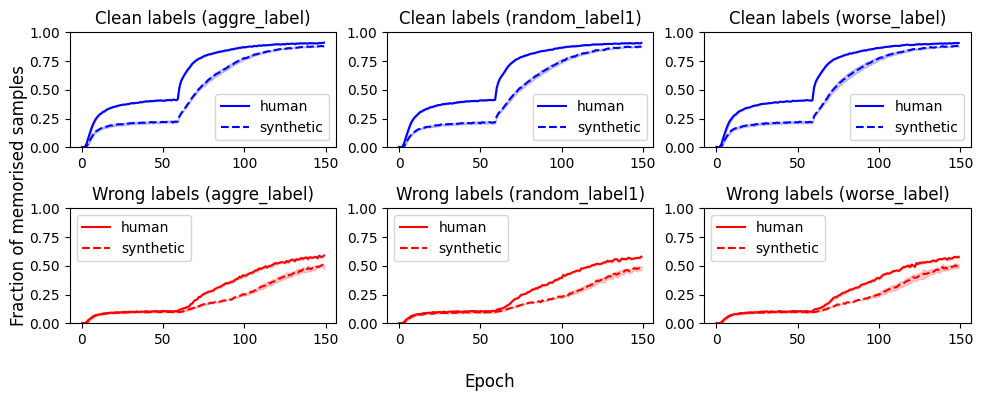

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))

for i, key in enumerate(keys_to_test):
    ax[0, i].set_title(f"Clean labels ({key})")
    ax[0, i].plot(memo_results_mean[key]["human"]["clean"], "b", label='human')
    ax[0, i].plot(memo_results_mean[key]["synthetic"]["clean"], "b--", label='synthetic')
    ax[0, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["human"]["clean"] - memo_results_unc[key]["human"]["clean"],
        memo_results_mean[key]["human"]["clean"] + memo_results_unc[key]["human"]["clean"],
        color="b", alpha=0.2
    )
    ax[0, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["synthetic"]["clean"] - memo_results_unc[key]["synthetic"]["clean"],
        memo_results_mean[key]["synthetic"]["clean"] + memo_results_unc[key]["synthetic"]["clean"],
        color="b", alpha=0.2
    )

    ax[1, i].set_title(f"Wrong labels ({key})")
    ax[1, i].plot(memo_results_mean[key]["human"]["wrong"], "r", label='human')
    ax[1, i].plot(memo_results_mean[key]["synthetic"]["wrong"], "r--",  label='synthetic')

    ax[1, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["human"]["wrong"] - memo_results_unc[key]["human"]["wrong"],
        memo_results_mean[key]["human"]["wrong"] + memo_results_unc[key]["human"]["wrong"],
        color="r", alpha=0.2
    )

    ax[1, i].fill_between(
        np.arange(150),
        memo_results_mean[key]["synthetic"]["wrong"] - memo_results_unc[key]["synthetic"]["wrong"],
        memo_results_mean[key]["synthetic"]["wrong"] + memo_results_unc[key]["synthetic"]["wrong"],
        color="r", alpha=0.2
    )

    ax[0, i].legend()
    ax[1, i].legend()
    ax[0, i].set_ylim(0, 1)
    ax[1, i].set_ylim(0, 1)

fig.supxlabel("Epoch")
fig.supylabel("Fraction of memorised samples")
plt.tight_layout()

plt.savefig("memorisation.pdf", dpi=600)
plt.show()